In [1]:
#bin data

from astropy import time
import matplotlib.pyplot as plt
import matplotlib as mpl
print(mpl.matplotlib_fname())
from astropy.table import Table, vstack
from matplotlib.colors import LogNorm,ListedColormap
import numpy as np
from astropy.io import fits
# adding a date stamp in the corner of the figure
import os, sys
import datetime
runtime = os.path.abspath((sys.argv[0])) + " run at " + datetime.datetime.now().strftime("%c")
tyb = dict(color='black', fontsize=8)

# add timestamp to plot
tya = dict(color='black', fontsize=8)

def rebintimeseries(t, f, tedges):
    from astropy.stats import sigma_clip
    tc_bin = np.array([])
    fc_bin = np.array([])
    fsigc_bin = np.array([])
    fc_npoi = np.array([])

    t_lower = tedges[:-1]
    t_upper = tedges[1:]
    t_midpoint = (t_lower+t_upper)/2.

    for t_mid, t_low, t_high in zip(t_midpoint, t_lower, t_upper):
        # select points from flux that have
        selpoints = ((t > t_low) * (t < t_high))
        fluxsel = f[selpoints]
        #fluxesel = flux_c[np.where(np.abs(time_c-t)<(dt/2))]
        if (fluxsel.size > 3):
        #    print('time {} has {} points'.format(t_mid, fluxsel.size))

            meanflux = sigma_clip(fluxsel, sigma=3, maxiters=2, masked=True)
            meane = np.ma.mean(meanflux)
            if np.isfinite(meane):
                tc_bin = np.append(tc_bin, t_mid)
                fc_bin = np.append(fc_bin, np.ma.mean(meanflux))
                fsigc_bin = np.append(fsigc_bin, np.ma.std(meanflux))
                fc_npoi = np.append(fc_npoi, np.sum(selpoints))

    return (tc_bin, fc_bin, fsigc_bin, fc_npoi)


    

/net/vdesk/data2/vbakker/Thesis1-jupyter/lib64/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


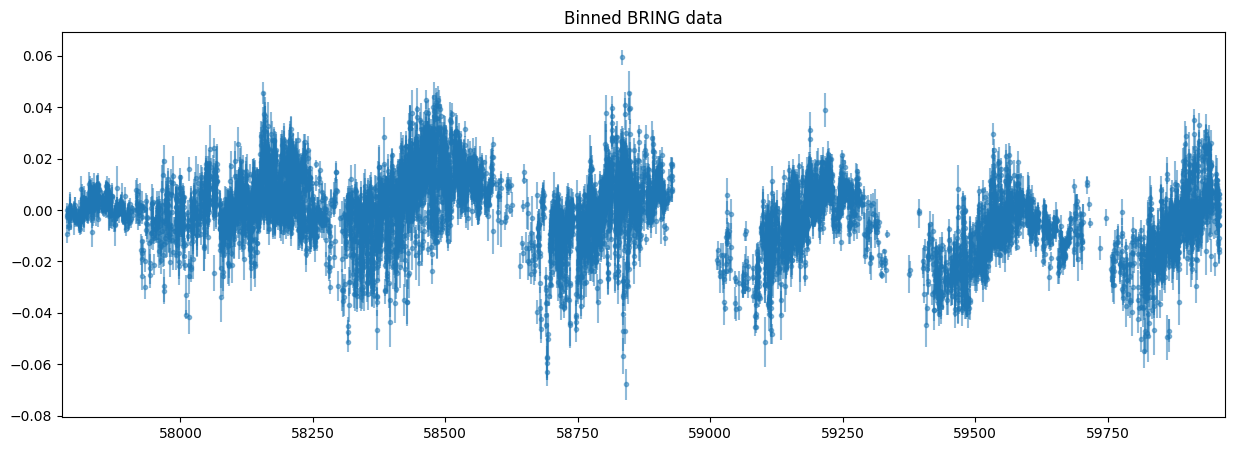

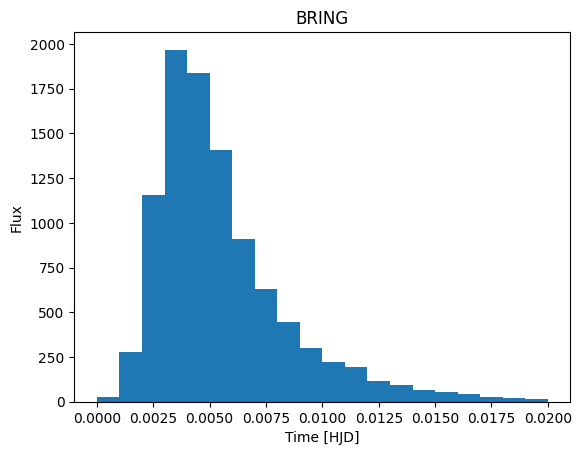

In [2]:
#Bin bring data
hdul = fits.open('Data/bring/Reduced_betaPic.fits')
primary = hdul[0].data
cols = hdul[1].columns

data_bRING = hdul[1].data
jd_bRing = data_bRING['jd']
raw_bRing = data_bRING['raw']
eraw_bRing = data_bRING['eraw']
reduced_bRing = data_bRING['reduced']
reducedHF_bRing = data_bRING['reducedHF']

#Get bring data en remove nan
x_bring = jd_bRing-2400000.5 #MJD
m = ~np.isnan(reduced_bRing)
time = x_bring[m]
y_bring_all = np.power(10.,(-reduced_bRing/2.5)) - 1.
y_bring = y_bring_all[m]
x_bring = time

local_midday = 0.68 # local offset for the middle of the day.
t_plot_start_epoch = np.min(x_bring) - 10. #bin for 50 days prior and 50 days after
t_plot_end_epoch = np.max(x_bring) + 10.

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xlim(t_plot_start_epoch, t_plot_end_epoch)
ax.set_title("All binned bRING data")


# epochs for rebinned flux
t_rebin = np.arange(t_plot_start_epoch, t_plot_end_epoch,0.05) #bin for every 0.05day

# BRING
plt.title('Binned BRING data')
(t_bring_binned, f_bring_binned, f_bring_sig_binned, n_poi) = rebintimeseries(x_bring, y_bring, t_rebin)
mc = (f_bring_sig_binned < 0.01)
t_bring_sel, f_bring_sel, f_bring_sig_sel = t_bring_binned[mc], f_bring_binned[mc], f_bring_sig_binned[mc]
ax.errorbar(t_bring_sel, f_bring_sel, yerr=f_bring_sig_sel, fmt='.', alpha=0.5)
plt.show()

#write binned data to file
dat = Table( [t_bring_sel, f_bring_sel, f_bring_sig_sel], names=('time','flux','ferr')  )
dat.write('Data/binned_BRING.dat', format='ascii.ecsv',  overwrite=True)

# show histograms of photometric errors
plt.hist(f_bring_sig_binned,bins=20,range=[0,0.02])
plt.title('BRING')
plt.xlabel('Time [HJD]')
plt.ylabel('Flux')
plt.draw()
plt.show()

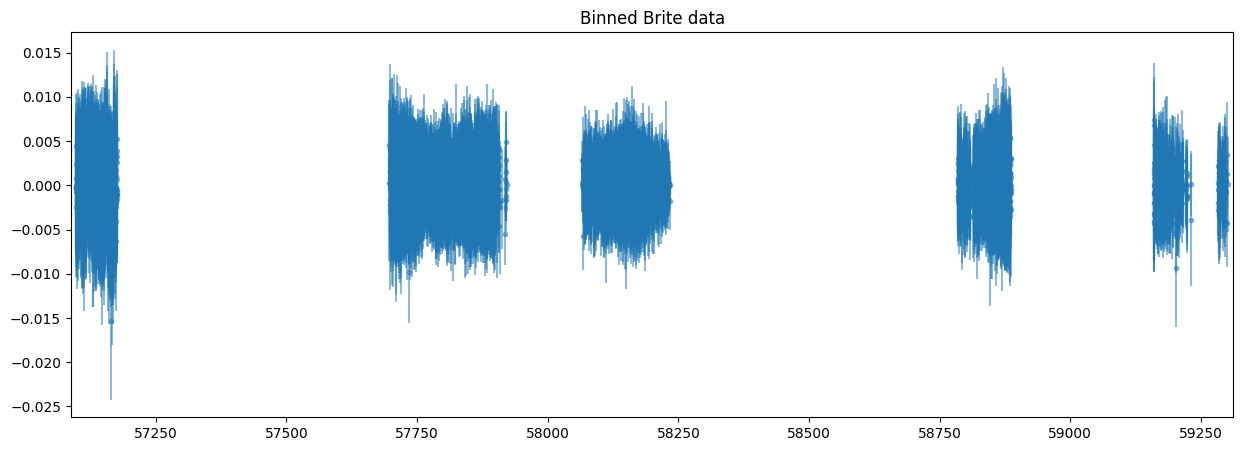

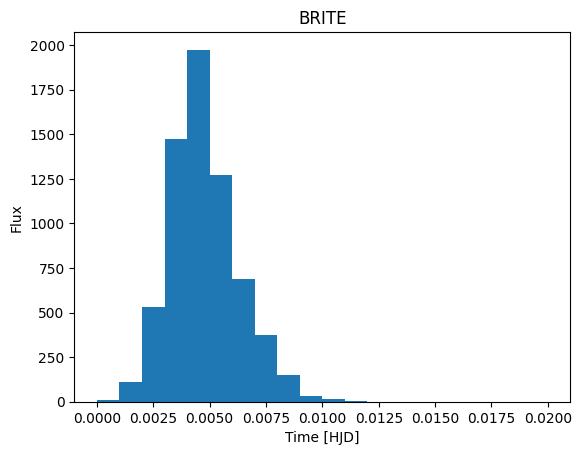

In [3]:
#bin BRITE data
fname_brite = 'Data/brite/brite_all_R.fits'
data_brite = Table.read(fname_brite)

x_brite = data_brite['time']
y_brite = data_brite['flux']

local_midday = 0.68 # local offset for the middle of the day.
t_plot_start_epoch = np.min(x_brite) - 10.
t_plot_end_epoch = np.max(x_brite) + 10.

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xlim(t_plot_start_epoch, t_plot_end_epoch)

# epochs for rebinned flux
plt.title('Binned Brite data')
t_rebin = np.arange(t_plot_start_epoch, t_plot_end_epoch, 0.05)
(t_brite_binned, f_brite_binned, f_brite_sig_binned, n_poi) = rebintimeseries(x_brite, y_brite, t_rebin)
mb = (f_brite_sig_binned < 0.01)
t_brite_sel, f_brite_sel, f_brite_sig_sel = t_brite_binned[mb], f_brite_binned[mb], f_brite_sig_binned[mb]
ax.errorbar(t_brite_sel, f_brite_sel, yerr=f_brite_sig_sel, fmt='.', alpha=0.5)
plt.show()

#write binned data to file
dat = Table( [t_brite_sel, f_brite_sel, f_brite_sig_sel], names=('time','flux','ferr')  )
dat.write('Data/binned_BRITE.dat', format='ascii.ecsv', overwrite=True)

# show histograms of photometric errors
plt.hist(f_brite_sig_binned,bins=20,range=[0,0.02])
plt.title('BRITE')
plt.xlabel('Time [HJD]')
plt.ylabel('Flux')
plt.draw()
plt.show()


In [ ]:
def river2(t, f, t_offset=0.68, scaler=100):
    'convert time series to a river plot assume f is around zero'
    day_count = np.floor(t - t_offset)
    f_moved = (f*scaler) + day_count
    return (t - day_count - t_offset, f_moved, day_count)

def circsel(x, y, yc=57780., xc=0.5, xw=0.4, yw=10.):
    'completely bonkers filter to select an ellipse in the river diagram'
    mask = np.sqrt(((x-xc)/xw)**2 + ((y-yc)/yw)**2)

    m = (mask<1)
    xsel = x[m]
    ysel = y[m]
    return (xsel, ysel, m)

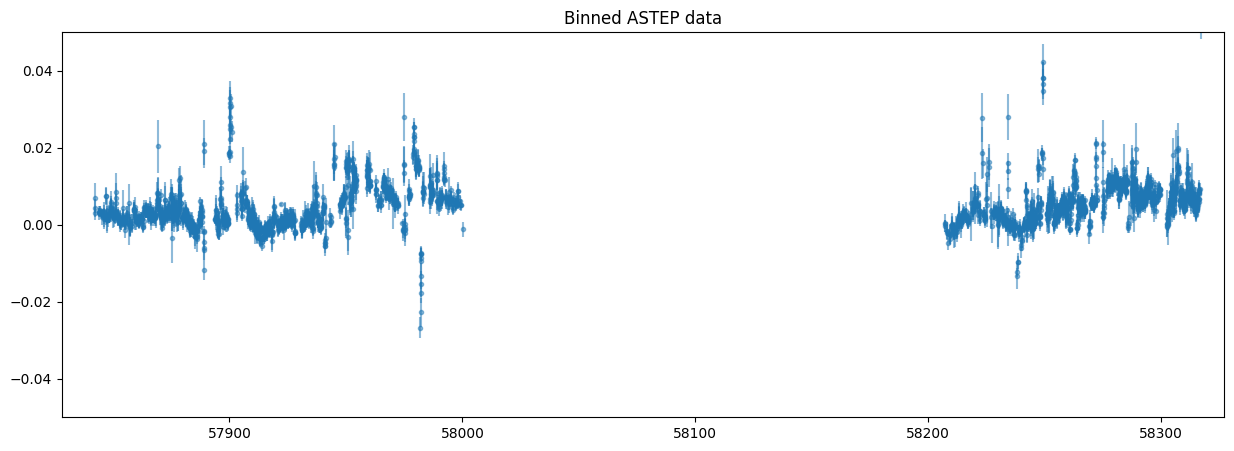

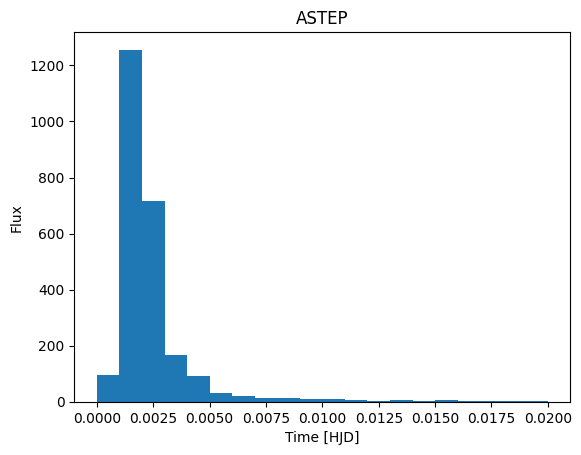

In [ ]:
#bin ASTEP data
data_astep = Table.read('Data/astep/astep_all.fits')
x_astep_all = data_astep['time']
y_astep_all = data_astep['flux']

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
local_midday = 0.68 # local offset for the middle of the day.
t_plot_start_epoch = np.min(x_astep_all ) - 10.
t_plot_end_epoch = np.max(x_astep_all)+10.
ax.set_xlim(t_plot_start_epoch, t_plot_end_epoch)


(x_aste, y_aste, day_count_aste) = river2(x_astep_all, y_astep_all, scaler=100)
# select 2017 ASTEP photoemtry mask
(xm2, ym2, mask2) = circsel(x_aste, day_count_aste, yc=57920,yw=80, xc=0.48, xw=0.35)
#ax.scatter(xm2, ym2, color='orange')

# select 2018 ASTEP photoemtry mask
(xm3, ym3, mask3) = circsel(x_aste, day_count_aste, yc=57920+365, yw=80, xc=0.48, xw=0.35)
#ax.scatter(xm3, ym3, color='pink')

x_astep_masked = x_aste[mask2+mask3]
y_astep_masked = y_aste[mask2+mask3]
x_astep_photom_masked = x_astep_all[mask2+mask3]
y_astep_photom_masked = y_astep_all[mask2+mask3]

# epochs for rebinned flux
plt.title('Binned ASTEP data')
t_rebin = np.arange(t_plot_start_epoch, t_plot_end_epoch, 0.05)
(t_astep_binned, f_astep_binned, f_astep_sig_binned, n_poi) = rebintimeseries(x_astep_photom_masked, y_astep_photom_masked, t_rebin)

ma = (f_astep_sig_binned < 0.007)
t_astep_sel, f_astep_sel, f_astep_sig_sel = t_astep_binned[ma], f_astep_binned[ma], f_astep_sig_binned[ma]
ax.errorbar(t_astep_sel, f_astep_sel, yerr=f_astep_sig_sel, fmt='.', alpha=0.5)
plt.ylim(-0.05, 0.05)
plt.show()

#write binned data to file
dat = Table( [t_astep_sel, f_astep_sel, f_astep_sig_sel], names=('time','flux','ferr')  )
dat.write('Data/binned_ASTEP.dat', format='ascii.ecsv', overwrite=True)

# show histograms of photometric errors
plt.hist( f_astep_sig_binned,bins=20,range=[0,0.02])
plt.title('ASTEP')
plt.xlabel('Time [HJD]')
plt.ylabel('Flux')
plt.draw()
plt.show()